1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import scipy.integrate as sc_in

Text(0.5, 1.0, 'Hist and Gaussian')

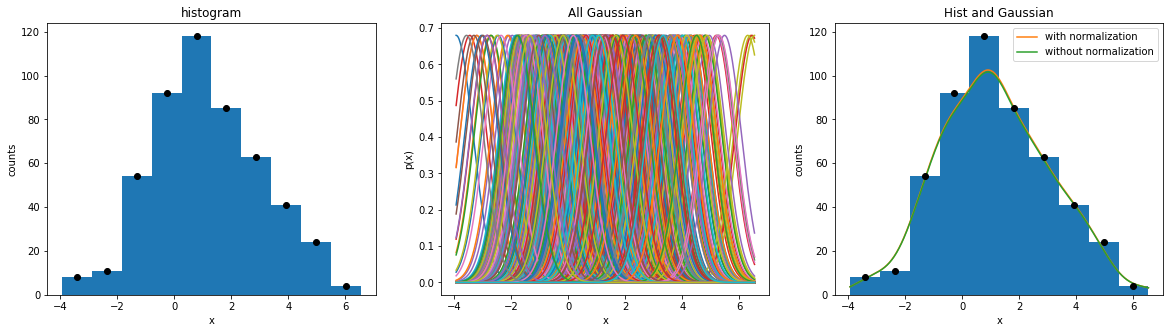

In [2]:

np.random.seed(2029007)
#####
fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(20,5))
#####
N=500
mean=1
sigma=2
#####
#-------------------------------------------------------------

x=np.random.normal(loc=mean,scale=sigma,size=N)
b=int((x.max()-x.min()))
count,bin1,_=ax1.hist(x,bins=b)
bin2=(1/2)*(bin1[1:] + bin1[:-1])

ax1.errorbar(bin2,count,yerr=1/(np.sqrt(count)),fmt='ko')
ax1.set(xlabel='x',ylabel='counts')
ax1.set_title('histogram')

#----------------------------------------------------------------------

original_std=1.06*x.std()*x.size**(-1/5)
gauss=np.zeros((N,N))
x1=np.linspace(x.min(),x.max(),num=N)
for i in range(N):
    gauss[i,:]=stats.norm.pdf(x1,loc=x[i],scale=original_std)
    ax2.plot(x1,gauss[i,:])
    

ax2.set(xlabel='x',ylabel='p(x)')
ax2.set_title('All Gaussian')

#------------------------------------------------------------

ax3.hist(x,bins=b)
ax3.errorbar(bin2,count,yerr=1/(np.sqrt(count)),fmt='ko')

G=np.sum(gauss,axis=0)
D=sc_in.trapz(G,dx=( x.max() - x.min() )/N)
ax3.plot(x1,(G/D)* N,label='with normalization')
ax3.plot(x1,G,label='without normalization')
ax3.legend()

ax3.set(xlabel='x',ylabel='counts')
ax3.set_title('Hist and Gaussian')

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

In [3]:
import seaborn as sns

<AxesSubplot:xlabel='x', ylabel='y'>

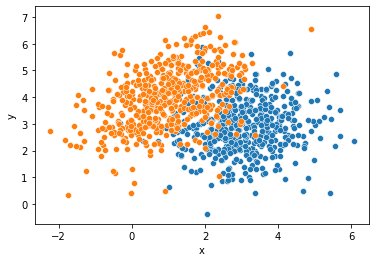

In [4]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image

Image('two_categories_scatter_plot.png')
#---------------------------------------

mean_1=[np.random.randint(5) for i in range(2)]
mean_2=[np.random.randint(5) for i in range(2)]
std_1=[[1,0],[0,1]]
std_2=[[1.2,0.5],[0.5,1.2]]
N=500

gauss_1=np.random.multivariate_normal(mean_1,std_1,N)
gauss_2=np.random.multivariate_normal(mean_2,std_2,N)
df_1=pd.DataFrame(gauss_1,columns=["x","y"])
df_2=pd.DataFrame(gauss_2,columns=["x","y"])
sns.scatterplot(data=df_1, x="x",y="y")
sns.scatterplot(data=df_2, x="x",y="y")

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [5]:
df=pd.DataFrame(np.load('residuals_261.npy',allow_pickle="False").item())
df=df[abs(df['residuals'])<2]
df

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


In [6]:
slope, intercept, r_value, p_value, std_err=stats.linregress(df['distances'],df['residuals'])
sns.jointplot(data=df,x='distances',y='residuals',kind='reg',color='red',joint_kws={'line_kws': {'color': 'black'}})

[ 0.          1.05263158  2.10526316  3.15789474  4.21052632  5.26315789
  6.31578947  7.36842105  8.42105263  9.47368421 10.52631579 11.57894737
 12.63157895 13.68421053 14.73684211 15.78947368 16.84210526 17.89473684
 18.94736842 20.        ]


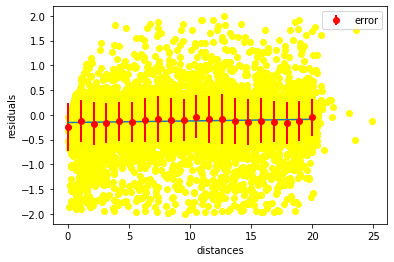

In [9]:
x = np.linspace(0,20,20)#np.array([i + 1/2 for i in range(20)])
print(x)

y = np.zeros(20)
yerr = np.zeros(20)

for i in range(20):
    y[i] = (df['residuals'][(df['distances'] > i) & (df['distances'] < i + 1)]).mean()
    yerr[i] = (df['residuals'][(df['distances'] > i) & (df['distances'] < i + 1)]).std()

plt.figure()  
y_predict= intercept+ slope*x 
plt.scatter(df["distances"],df["residuals"],color='yellow')
plt.plot(x,y_predict)
#g=sns.jointplot(x='distances',y='residuals',data=df,kind='reg',joint_kws={'line_kws': {'color': 'blue'}})
plt.errorbar(x=x,y=y,yerr=yerr,label='error',linewidth=2,fmt='o',c='red')
plt.xlabel('distances')
plt.ylabel('residuals')
plt.legend()
plt.show()